# Check of Hybrid BSS code

We compare smiles generated using the exact method for 2013-08-14 with those generated using the hybrid BSS code.

In [1]:
source("hybridSimulation.R")
source("BlackScholes.R")

In [2]:
# library(repr)
library(stinepack)
library(foreach)
library(doParallel)

Loading required package: iterators
Loading required package: parallel


In [3]:
options(repr.plot.width=10,repr.plot.height=7)

# GRID

The first column is maturities (later there is a vector t_exp). If you plot them they are more or less log-uniform.
X0-X10 correspond to strikes for a given maturity. The greater the maturity, the greater the range.

**You need to produce 8 by 11 vol surface with these parameters!!!**

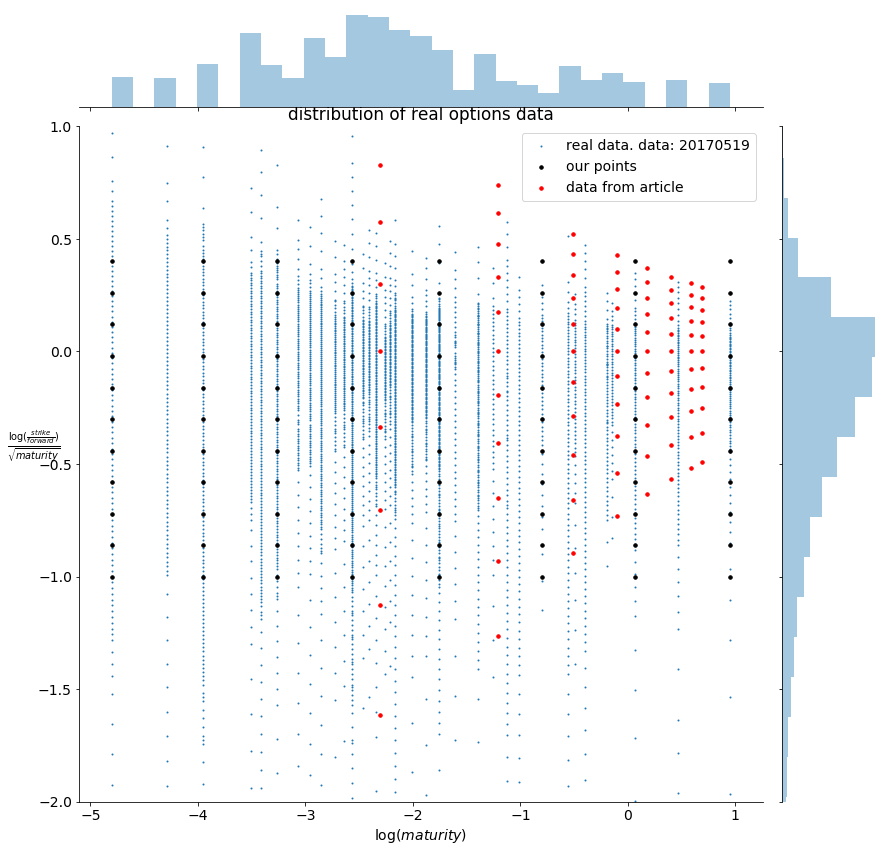

In [4]:
fname = "data/maturity_strike_grid.csv"
maturity_strike_grid <- read.csv(fname)

In [5]:
maturity_strike_grid

,maturities,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
1,0.008213552,0.9133568,0.9250193,0.9368308,0.948793,0.960908,0.9731777,0.985604,0.9981891,1.010935,1.023843,1.036917
2,0.01916496,0.8707176,0.8877578,0.9051315,0.9228452,0.9409055,0.9593193,0.9780935,0.9972351,1.016751,1.036649,1.056937
3,0.03832991,0.8221929,0.8450402,0.8685225,0.8926573,0.9174627,0.9429575,0.9691607,0.9960921,1.023772,1.052221,1.08146
4,0.07665982,0.7581492,0.788114,0.819263,0.8516433,0.8853032,0.9202936,0.9566669,0.9944778,1.033783,1.074642,1.117116
5,0.1724846,0.6601339,0.6996543,0.7415408,0.7859349,0.8329867,0.8828554,0.9357097,0.9917281,1.0511,1.114027,1.180721
6,0.4517454,0.5106249,0.5610062,0.6163585,0.6771722,0.7439862,0.8173924,0.8980413,0.9866475,1.083996,1.19095,1.308456
7,1.073238,0.3548814,0.4102717,0.4743074,0.5483379,0.6339231,0.7328666,0.8472534,0.9794937,1.132374,1.309117,1.513445
8,2.587269,0.2001879,0.2507474,0.3140763,0.3933996,0.4927568,0.6172077,0.77309,0.968342,1.212907,1.519239,1.902939


# Forward Var curves

There are two files, the first one is params, the second one is curves themselves. The columns names for curves are t_exp, you can see they coincide. 

In [6]:
fname = "data/forward_var_params.csv"
forward_var_params <- read.csv(fname)

In [7]:
head(forward_var_params)

,intercept,linear,square_root,inv_square_root
1,0.1846364,-0.09757776,0.1838998,0.06292971
2,0.1856152,0.0011851,0.02572286,-0.03508866
3,0.4914271,0.1609238,-0.42759,-0.07830187
4,0.3610892,0.07312348,-0.1582807,0.01754187
5,0.06959509,-0.01617112,0.1550531,0.02819991
6,0.2484897,-0.05488642,0.06224921,0.007841998


# heston params

In [8]:
fname = "data/heston_params.csv"
heston_params <- read.csv(fname)

In [9]:
head(heston_params)

,S0,eta,rho,H
1,1,0.8057238,-0.4833544,0.02765358
2,1,1.30667,-0.9041051,0.2712924
3,1,1.938714,-0.303518,0.212533
4,1,1.587739,-0.2288472,0.25494
5,1,2.480846,-0.1119621,0.227355
6,1,2.407723,-0.8425001,0.2836722


# To Do

1) t_exp is const, pass it to all samples.
2) forward_var curve should be different for all vol_surfcaces, just iterate from csv file. Save the params as well!
3) save 8 * 11 point from vol survace given by grid file.

So, to sum up, save:
- 4 params for forward_var curve,
- forward_var curve itself (8 points)
- params for model (**(ξ0, ν, ρ, H) ∈ U[0.01, 0.16]^8×U[0.5, 4.0]×U[−0.95, −0.1]×U[0.025, 0.5]** please read page 27 of the article. Instead of the first param you should somehow put forward_var curve, read Jim's code below)
- 8 by 11 points on the surface.

In total: 4 + 8 + 3 + 8*11. We can store each of the vol survace in a separate csv file or h5py...

We now build a function of time so we can used the revised Hybrid BSS code.

### Test revised Hybrid BSS code

We use the above $\xi_t(u)$ curve from the exact simulation as input to the revised Hybrid simulation.

We see that the vectorized code is very fast:  Only 53 seconds to get 20 expiries x 100,000 paths.

In [8]:
xi3 <-function(coefs){    
    inner_func <<- function(t){
        ans = (coefs$intercept 
             + coefs$linear * t 
             + coefs$square_root * sqrt(t)
             + coefs$inv_square_root / sqrt(t))
        ans = pmax(0.1, pmin( ans, 0.5))
        return(ans)
    }
    return(inner_func)
}

In [ ]:
forward_var_params

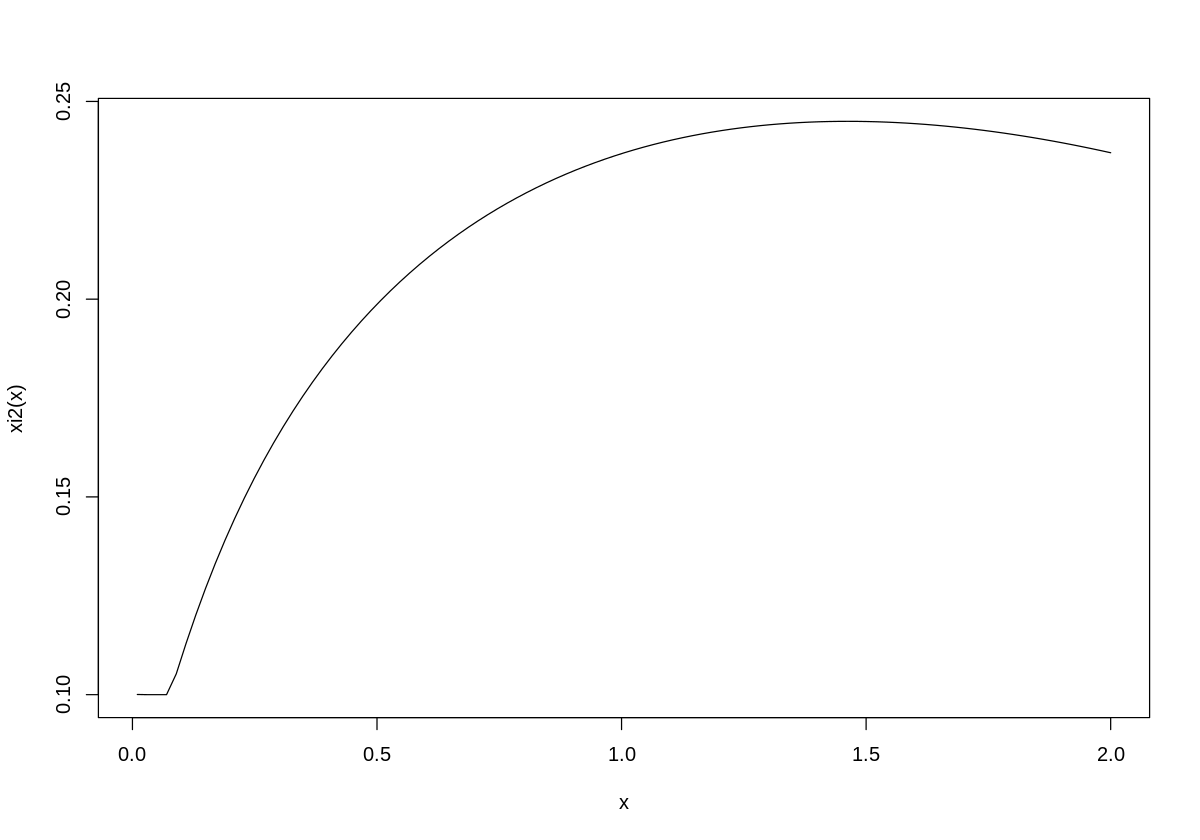

In [11]:
xi2 = xi3(forward_var_params[30,])
curve(xi2, from=0.01, to=2)

In [12]:
split_into = 24
paths <- 10000
steps <- 200
iters <- max(1,floor(paths/split_into))
expiries <- (maturity_strike_grid$maturities)

In [13]:
start = 1
stop  = 30000

In [14]:
cl.num <<- 8

In [16]:
heston_params[1, ]



,S0,eta,rho,H
1,1,0.8057238,-0.4833544,0.02765358


In [ ]:
# -0.9 2.3 0.05 

In [43]:
heston_params = list(S0=1, eta=2.3, rho=-0.9,  H=0.05)


In [47]:
xi2 <- function(t) {0.05 + 0.1* t**0.2}

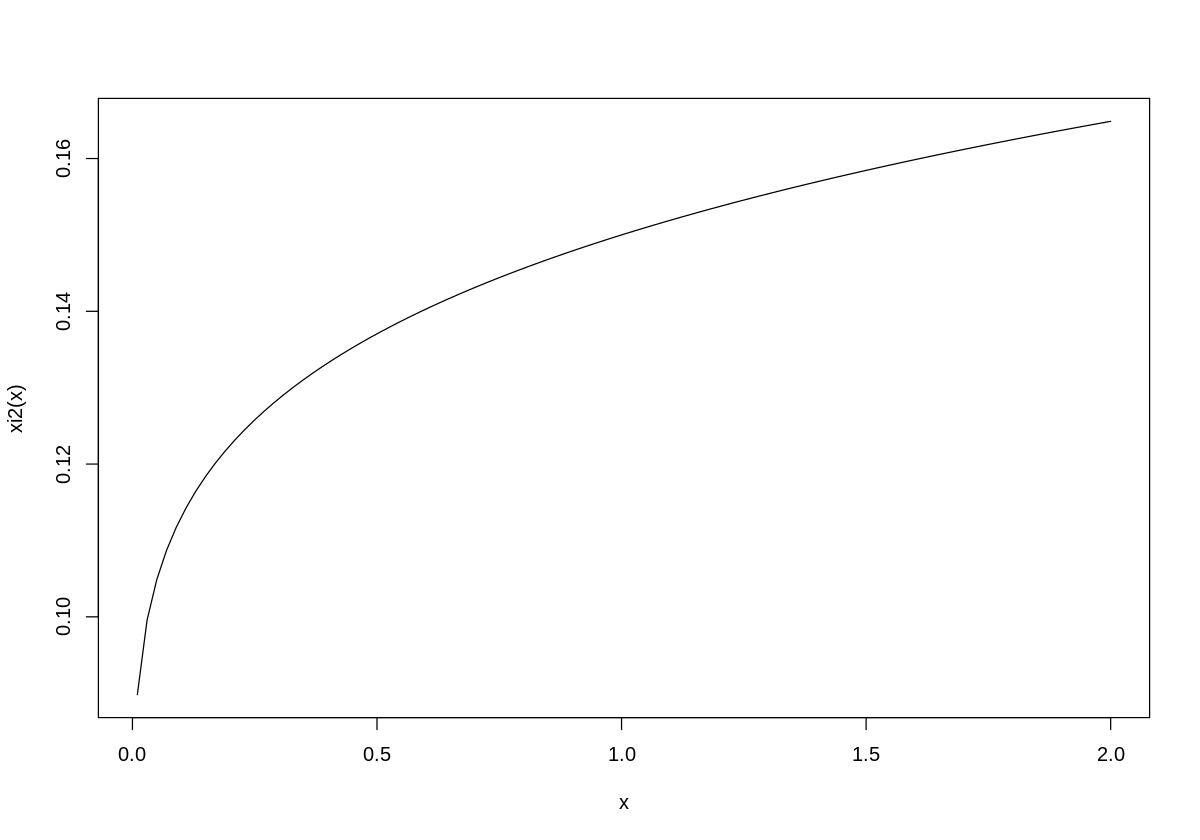

In [48]:
curve(xi2, from=0.01, to=2)

In [49]:

# cluster
cl<-makeCluster(cl.num)
registerDoParallel(cl)
ls <- foreach(icount(iters)) %dopar% {
    hybridScheme(xi2, heston_params)(N=split_into,
                                          steps=steps,
                                          expiries=expiries)
}
stopCluster(cl)
mcMatrix <- do.call(cbind, ls) #Bind all of the submatrices into one big matrix


data <- c()
for (slice in 1:nrow(mcMatrix)){
    current_strikes <- maturity_strike_grid[slice,c(2,3,4,5,6,7,8,9,10,11,12)]
    t     <- expiries[slice]
    spots <- mcMatrix[slice,]
    s0    <<- mean(spots)
    volMC <- function(strike) { bsOut(spots, t, s0 * strike)$BSV}
    data  <- rbind(data, c(sapply(current_strikes, volMC)))
}

write.csv(data, 
          file = paste("data/20130814.csv", sep=""),
          row.names=FALSE)


## Plot function

In [47]:
plotIvolsRoughMC <- function (ivolData, sviMatrix = NULL, slices = NULL, mcMatrix = NULL, mcMatrix2 = NULL, 
    plot = TRUE, colnum = NULL) 
{
    bidVols <- as.numeric(ivolData$Bid)
    askVols <- as.numeric(ivolData$Ask)
    expDates <- unique(ivolData$Texp)
    nSlices <- length(expDates)
    if (!is.null(slices)) {
        nSlices <- length(slices)
    }
    else {
        slices <- 1:nSlices
    }
    colnum <- sqrt(nSlices * 2)
    rows <- round(colnum/2, 0)
    columns <- round(colnum, 0)
    while (rows * columns < nSlices) {
        rows <- rows + 1
    }
    atmVol <- numeric(nSlices)
    atmSkew <- numeric(nSlices)
    atmVolMC <- numeric(nSlices)
    atmSkewMC <- numeric(nSlices)
    atmVolMC2 <- numeric(nSlices)
    atmSkewMC2 <- numeric(nSlices)
    par(mfrow = c(rows, columns), mex = 0.5)
    for (slice in slices) {
        t <- expDates[slice]
        texp <- ivolData$Texp
        bidVol <- bidVols[texp == t]
        askVol <- askVols[texp == t]
        midVol <- (bidVol + askVol)/2
        f <- (ivolData$Fwd[texp == t])[1]
        k <- log(ivolData$Strike[texp == t]/f)
        include <- !is.na(bidVol) & (bidVol > 0)
        kmin <- min(k[include])
        kmax <- max(k[include])
        ybottom <- 0.6 * min(bidVol[include])
        ytop <- 1.2 * max(askVol[include], na.rm = T)
        xrange <- c(kmin, kmax)
        yrange <- c(ybottom, ytop)
        
        kIn <- k[!is.na(midVol)]
        volIn <- midVol[!is.na(midVol)]
        volInterp <- function(xout) {
            stinterp(x = kIn, y = volIn, xout)$y
        }
        atmVol[slice] <- volInterp(0)
        atmSkew[slice] <- (volInterp(0.01) - volInterp(-0.01))/0.02
        
        bidVolN <- bidVol/atmVol[slice]
        askVolN <- askVol/atmVol[slice]
        yrangeN <- yrange/atmVol[slice]
        
        if (plot == TRUE) {
            plot(k, bidVolN, col = "red", pch = 24, cex = 0.5, 
                xlim = xrange, ylim = yrangeN, main = paste("T =", 
                  format(t, digits = 2, nsmall = 2)), xlab = "Log-Strike", 
                ylab = "Implied Vol.")
            points(k, askVolN, col = "blue", pch = 25, cex = 0.5)
                
            abline(v = 0, lty = 2)
            abline(h = 1, lty=2)
            if ((!is.null(sviMatrix))) {
                vol <- function(k) {
                  sqrt(svi(sviMatrix[slice, ], k)/t)
                }
                par(new = T)
                curve(vol(x), from = kmin, to = kmax, col = "orange", 
                  lwd = 2, add = T)
            }
            if ((!is.null(mcMatrix))) {
                spots <- mcMatrix[slice, ] # Note that slices line up with rows of mcMatrix
                s0 <- mean(spots)
                volMC <- function(k) {
                  bsOut(spots, t, s0 * exp(k))$BSV
                }
                atmVolMC[slice] <- volMC(0)
                atmSkewMC[slice] <- (volMC(0.01) - volMC(-0.01))/0.02
                curve(volMC(x)/atmVolMC[slice], from = kmin, to = kmax, col = "orange", 
                  lwd = 2, add = T)
            }
            if ((!is.null(mcMatrix2))) {
                spots <- mcMatrix2[slice, ] # Note that slices line up with rows of mcMatrix
                s0 <- mean(spots)
                volMC <- function(k) {
                  bsOut(spots, t, s0 * exp(k))$BSV
                }
                atmVolMC2[slice] <- volMC(0)
                atmSkewMC2[slice] <- (volMC(0.01) - volMC(-0.01))/0.02
                curve(volMC(x)/atmVolMC2[slice], from = kmin, to = kmax, col = "green4", 
                  lwd = 2, lty=2, add = T)
            }
        }
        
    }
    par(mfrow = c(1, 1), mex = 1)
    par(new = F)
    return(list(expiries = expDates, atmVol = atmVol, atmSkew = atmSkew, 
        atmVolMC = atmVolMC, atmSkewMC = atmSkewMC))
}